# Clustering
The goal of this phase is to segment products based on their sales behavior over time, identifying groups with similar demand patterns. This supports later forecasting, inventory planning, and category decisions.


In [1]:
# Import necessary libraries
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
current = Path.cwd()

while current != current.parent:
    candidate = current / "data_cleaned" / "master.parquet"
    if candidate.exists():
        master_path = candidate
        break
    current = current.parent

df = pd.read_parquet(master_path)
df.head()

,ID_Venta,Fecha,ID_Cliente,ID_Producto,Cantidad,Método_Pago,Estado,Nombre,Apellido,Email,...,Stock,ID_Categoria,Descripción_x,ID_Metodo,Método,Descripción_y,anio,mes,semana,ingreso
0,919,2024-01-31,10,25,5,1,Completa,Stephenie,Sexty,ssexty9@domainmarket.com,...,1640,5,"Productos congelados, como papas fritas, empan...",1,Efectivo,"Pago en dinero en efectivo, sin intermediarios...",2024,1,5,77.25
1,947,2024-01-31,106,5,1,4,Completa,Benedikta,Condon,bcondon2x@paypal.com,...,4929,1,"Productos lácteos frescos y procesados, como l...",4,Mercado Pago,Plataforma de pagos online que permite realiza...,2024,1,5,5.65
2,1317,2024-01-31,235,25,3,3,Completa,Cloe,Brun,cbrun6i@theglobeandmail.com,...,1640,5,"Productos congelados, como papas fritas, empan...",3,Tarjeta de Débito,Pago con tarjetas que debitán directamente de ...,2024,1,5,46.35
3,1607,2024-01-31,114,15,5,1,Completa,Fabien,Roskam,froskam35@desdev.cn,...,4043,3,"Productos horneados frescos, como pan, factura...",1,Efectivo,"Pago en dinero en efectivo, sin intermediarios...",2024,1,5,17.55
4,2038,2024-01-31,132,2,5,4,Completa,Cassie,Corish,ccorish3n@virginia.edu,...,3358,1,"Productos lácteos frescos y procesados, como l...",4,Mercado Pago,Plataforma de pagos online que permite realiza...,2024,1,5,26.05


## Aggregate Monthly Demand per Product

In [3]:
# Extract year and month from date
df["anio"] = df["Fecha"].dt.year
df["mes"] = df["Fecha"].dt.month

# Aggregate demand per product per month
prod_mes = (
    df.groupby(["ID_Producto", "anio", "mes"], as_index=False)
      .agg(
          ingreso_mensual=("ingreso", "sum"),
          unidades_mensuales=("Cantidad", "sum")
      )
)

prod_mes.head()

,ID_Producto,anio,mes,ingreso_mensual,unidades_mensuales
0,1,2024,2,318.24,26
1,1,2024,3,367.20,30
2,1,2024,4,428.40,35
3,1,2024,5,171.36,14
4,1,2024,6,354.96,29


## Pivot to Product × Month Matrix


In [4]:
mat_prod = prod_mes.pivot_table(
    index="ID_Producto",
    columns="mes",
    values="ingreso_mensual",
    aggfunc="sum",
    fill_value=0
)

# Sort columns in calendar order
mat_prod = mat_prod.reindex(sorted(mat_prod.columns), axis=1)

mat_prod.head()

mes,1,2,3,4,5,6,7,8,9,10,11,12
ID_Producto,,,,,,,,,,,,
1,0.00,318.24,367.20,428.40,171.36,354.96,367.20,146.88,183.60,220.32,440.64,379.44
2,26.05,93.78,140.67,104.20,130.25,135.46,104.20,114.62,203.19,140.67,57.31,171.93
3,51.69,516.90,620.28,465.21,447.98,465.21,241.22,327.37,465.21,379.06,172.30,465.21
4,0.00,596.13,480.75,615.36,403.83,730.74,384.60,384.60,538.44,192.30,249.99,403.83
5,5.65,101.70,107.35,169.50,265.55,146.90,141.25,192.10,175.15,101.70,192.10,96.05


## Create Derived Features (yearly revenue, monthly volability and stability indicator)

In [6]:
features = mat_prod.copy()

# Total yearly revenue
features["total_year"] = features.sum(axis=1)

# Monthly volatility
features["std_month"] = features.iloc[:, 0:12].std(axis=1)

# Coefficient of variation (stability indicator)
features["coef_var"] = features["std_month"] / (features["total_year"] / 12 + 1e-6)

features.head()

mes,1,2,3,4,5,6,7,8,9,10,11,12,total_year,std_month,coef_var
ID_Producto,,,,,,,,,,,,,,,
1,0.00,318.24,367.20,428.40,171.36,354.96,367.20,146.88,183.60,220.32,440.64,379.44,3378.24,135.094440,0.479875
2,26.05,93.78,140.67,104.20,130.25,135.46,104.20,114.62,203.19,140.67,57.31,171.93,1422.33,47.445859,0.400294
3,51.69,516.90,620.28,465.21,447.98,465.21,241.22,327.37,465.21,379.06,172.30,465.21,4617.64,160.346476,0.416697
4,0.00,596.13,480.75,615.36,403.83,730.74,384.60,384.60,538.44,192.30,249.99,403.83,4980.57,200.760117,0.483704
5,5.65,101.70,107.35,169.50,265.55,146.90,141.25,192.10,175.15,101.70,192.10,96.05,1695.00,65.580724,0.464288


## Standardize Data

In [8]:
X = features.values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
features_scaled = pd.DataFrame(X_scaled, index=features.index, columns=features.columns)
features_scaled.head()

mes,1,2,3,4,5,6,7,8,9,10,11,12,total_year,std_month,coef_var
ID_Producto,,,,,,,,,,,,,,,
1,-0.307541,0.484480,0.608786,1.361703,-0.428117,0.524792,0.733454,-0.447787,-0.290752,-0.124986,1.356686,0.545045,0.415478,0.297563,-0.588728
2,0.881752,-0.733956,-0.732350,-0.857990,-0.668146,-0.841813,-0.905687,-0.607266,-0.205623,-0.666060,-1.146239,-0.395694,-0.806536,-1.051502,-1.593980
3,2.052326,1.562867,2.107108,1.613730,1.186991,1.211207,-0.051713,0.444473,0.932985,0.953355,-0.395420,0.933880,1.189831,0.686236,-1.386779
4,-0.307541,1.992951,1.281042,2.641758,0.929211,2.864395,0.841900,0.727392,1.251206,-0.315330,0.111851,0.655616,1.416582,1.308273,-0.540362
5,-0.049595,-0.690964,-0.929616,-0.410902,0.121833,-0.770588,-0.674774,-0.224240,-0.327471,-0.930788,-0.266138,-0.739693,-0.636178,-0.772375,-0.785617


## Determine Optimal Number of Clusters (Elbow + Silhouette)

In [9]:
inertias = []
silhouettes = []
k_values = range(2, 11)

for k in k_values:
    model = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = model.fit_predict(X_scaled)
    inertias.append(model.inertia_)
    silhouettes.append(silhouette_score(X_scaled, labels))

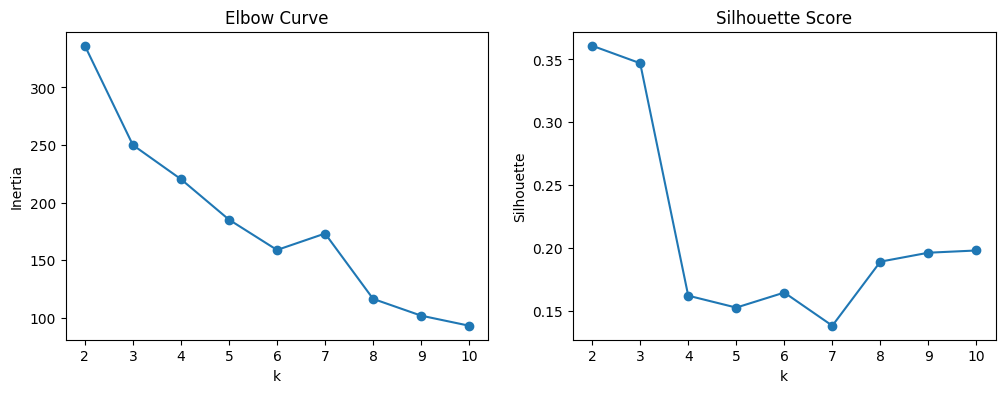

In [10]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(k_values, inertias, marker="o")
plt.title("Elbow Curve")
plt.xlabel("k")
plt.ylabel("Inertia")

plt.subplot(1,2,2)
plt.plot(k_values, silhouettes, marker="o")
plt.title("Silhouette Score")
plt.xlabel("k")
plt.ylabel("Silhouette")

plt.show()

- The Elbow Curve shows a clear inflection at k = 3, indicating diminishing returns in inertia reduction beyond this point.
- The Silhouette Score is highest at k = 2, but the value for k = 3 remains strong and much higher than k ≥ 4, where the score drops sharply.

Considering both metrics together, and balancing separation quality with practical interpretability, the selected number of clusters is: k = 3.

## Run Final K-Means 

In [11]:
k_opt = 3

kmeans_final = KMeans(n_clusters=k_opt, random_state=42, n_init="auto")
labels_final = kmeans_final.fit_predict(X_scaled)

features["cluster"] = labels_final
clusters_prod = features.reset_index()

## Add Product Names and Categories

In [12]:
# Extract product names and categories (run this BEFORE merging)
prod_info = df[["ID_Producto", "Nombre_producto", "Categoría"]].drop_duplicates()

# Reset index correctly and preserve ID_Producto
clusters_prod = features.reset_index().rename(columns={"index": "ID_Producto"})

# Add product names + categories
clusters_prod = clusters_prod.merge(
    prod_info,
    on="ID_Producto",
    how="left"
)

# Compute payment mix per product
payment_mix = (
    df.groupby(["ID_Producto", "Método_Pago"])
      .size()
      .reset_index(name="count")
)

# Normalize within each product
payment_mix["pct_pago"] = (
    payment_mix.groupby("ID_Producto")["count"]
               .transform(lambda x: x / x.sum())
)

# Pivot to wide format
payment_pivot = payment_mix.pivot(
    index="ID_Producto",
    columns="Método_Pago",
    values="pct_pago"
).fillna(0)

# Merge into clusters_prod
clusters_prod = clusters_prod.merge(
    payment_pivot,
    on="ID_Producto",
    how="left"
)


## Cluster Summary Table


In [13]:
# Here we assume margin = 35% (adjust if needed)
df["margen"] = df["ingreso"] * 0.35

margin_prod = df.groupby("ID_Producto")["margen"].sum().reset_index()

clusters_prod = clusters_prod.merge(
    margin_prod,
    on="ID_Producto",
    how="left"
)

cluster_profile = (
    clusters_prod.groupby("cluster")
    .agg(
        avg_total_year=("total_year", "mean"),
        avg_volatility=("std_month", "mean"),
        avg_coef_var=("coef_var", "mean"),
        avg_margin=("margen", "mean"),
        count_products=("ID_Producto", "count")
    )
)
cluster_profile.sort_values(by="avg_total_year", ascending=False)

cluster_profile

,avg_total_year,avg_volatility,avg_coef_var,avg_margin,count_products
cluster,,,,,
0,1574.738571,69.859412,0.540423,551.1585,21
1,3843.390000,160.620835,0.509298,1345.1865,16
2,8539.440000,361.967763,0.508653,2988.8040,1


In [14]:
# Identify payment columns that exist in clusters_prod
payment_cols = [col for col in payment_pivot.columns if col in clusters_prod.columns]

# Compute payment mix per cluster
payment_cluster_profile = (
    clusters_prod.groupby("cluster")[payment_cols]
    .mean()
)

payment_cluster_profile

""
cluster
0
1
2


## Heatmap of Monthly Patterns

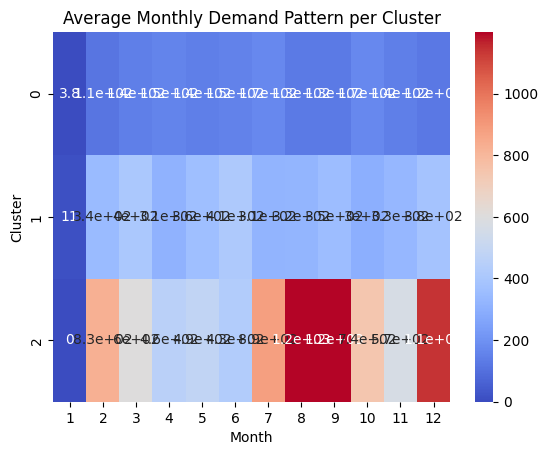

In [15]:
monthly_cols = list(mat_prod.columns)

cluster_month_pattern = (
    features.groupby("cluster")[monthly_cols]
    .mean()
)

sns.heatmap(cluster_month_pattern, annot=True, cmap="coolwarm")
plt.title("Average Monthly Demand Pattern per Cluster")
plt.xlabel("Month")
plt.ylabel("Cluster")
plt.show()

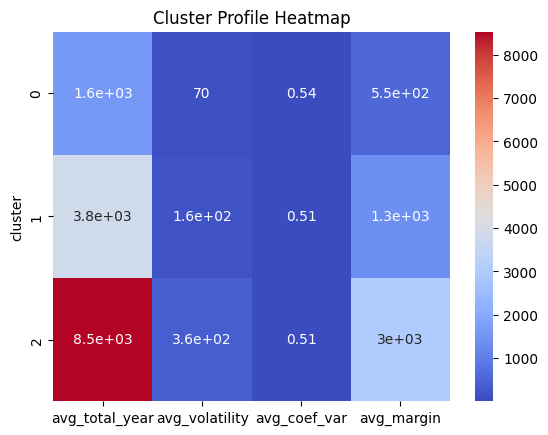

In [14]:
sns.heatmap(cluster_profile.drop(columns="count_products"),
            annot=True, cmap="coolwarm")
plt.title("Cluster Profile Heatmap")
plt.show()